**OpenClassrooms - Parcours Datascience**

**Projet 6: Classifiez automatiquement des biens de consommation**  
  
**Etudiant: Vincent GAGNOT**

Pour ce projet, je suis Data Scientist au sein de l’entreprise "Place de marché”,  
qui souhaite lancer une marketplace e-commerce.  
Sur la place de marché, des vendeurs proposent des articles à des acheteurs  
en postant une photo et une description. Pour l'instant, l'attribution de la catégorie  
d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable.  
On nous demande donc d'étudier la faisabilité d'un moteur de classification des articles  
en différentes catégories.

# Imports

In [184]:
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import time
import matplotlib.pyplot as plt
import keras.preprocessing.image
import keras.applications.resnet
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from random import sample
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from keras.applications.vgg16 import VGG16
from keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD

In [185]:
# Import database
data0 = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv", delimiter=',')

In [186]:
# Ouverture image
list_img = []
for img_id in data0['image']:
    globals()[img_id[:-4]] = Image.open(img_id)
    list_img.append(globals()[img_id[:-4]])

C:\Users\vince\anaconda3\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [187]:
data0['image2'] = list_img

# Création de la référence

Pour évaluer la qualité de ma classification, je vais la comparer à celle proposée par  
les utilisateurs, pour les 1050 produits déjà référencés. Elle est sous forme  
d'arborescence.  
A partir du niveau de base de l'arborescence, je créé une nouvelle variable, qui sera ma  
référence.

In [188]:
def prod_cat_0 (row):
    debut = row['product_category_tree'].index('["')+2
    fin = row['product_category_tree'].index(' >>')
    return row['product_category_tree'][debut :fin]

In [189]:
data0['prod_cat_0'] = data0.apply(lambda x : prod_cat_0(x), axis = 1)

In [190]:
categ_0 = data0['prod_cat_0'].unique()
categ_0

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

J'obtiens donc 7 catégories différentes. La répartition des produits entre les catégories  
est la suivante:

In [191]:
for k in categ_0:
    nb = len(data0['prod_cat_0'][data0['prod_cat_0'] == k])
    print(str(k) + ': ' + str(nb) + ' items.')

Home Furnishing: 150 items.
Baby Care: 150 items.
Watches: 150 items.
Home Decor & Festive Needs: 150 items.
Kitchen & Dining: 150 items.
Beauty and Personal Care: 150 items.
Computers: 150 items.


J'applique un label encoder sur les étiquettes obtenues pour mesures de similarité.

In [192]:
le = preprocessing.LabelEncoder()
le.fit(categ_0)
data0['prod_cat_0_bis'] = le.transform(data0['prod_cat_0'])

Je note aussi les 2 niveaux de catégorie suivants, à des fins d'analyse exploratoire.

In [193]:
def prod_cat_1_2 (row):
    k1 = 0
    k2 = 0
    k3 = 0
    
    k1 = row['product_category_tree'].find(' >> ', 0)
    k2 = row['product_category_tree'].find(' >> ', k1+1) 
    k3 = row['product_category_tree'].find(' >> ', k2+1) 
    
    cat1 = row['product_category_tree'][k1+4 :k2]
    cat2 = row['product_category_tree'][k2+4 :k3]
    
    return [cat1, cat2]

In [194]:
data0['prod_cat_1'] = data0.apply(lambda x : prod_cat_1_2(x)[0], axis = 1)
data0['prod_cat_2'] = data0.apply(lambda x : prod_cat_1_2(x)[1], axis = 1)

# Analyse exploratoire préliminaire

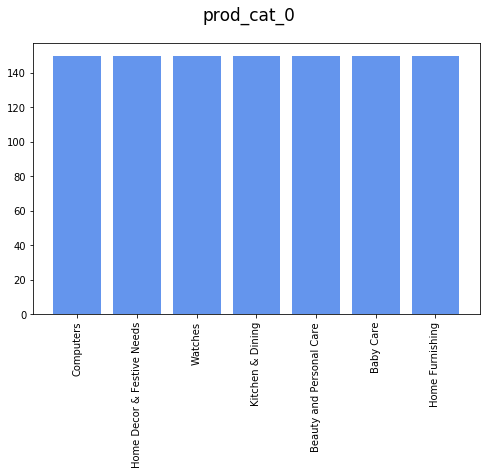

In [195]:
nombre_vals = data0['prod_cat_0'].value_counts()
plt.rcParams["figure.figsize"] = (8,5)
plt.bar(nombre_vals.index, nombre_vals.values, color=['cornflowerblue'])
plt.suptitle('prod_cat_0', fontsize=17)
plt.xticks(rotation=90)  
plt.show()

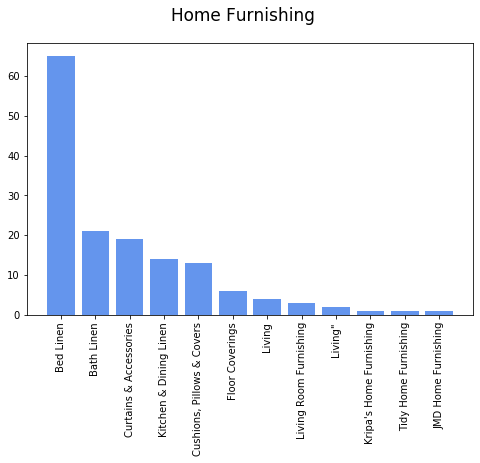

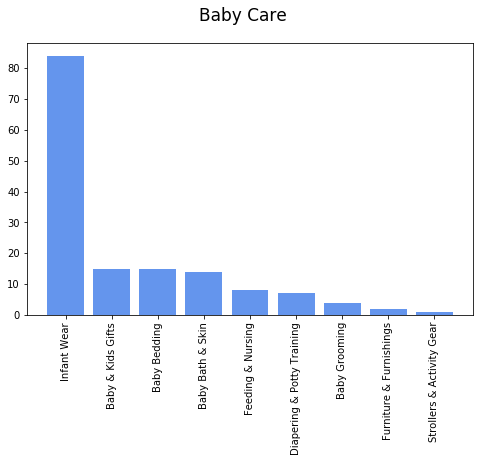

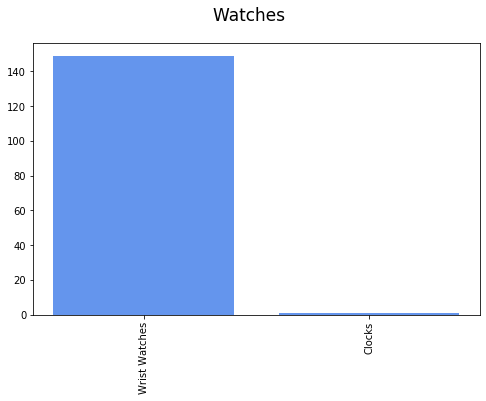

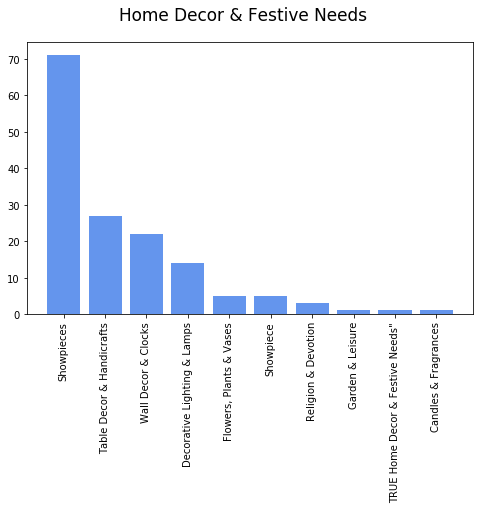

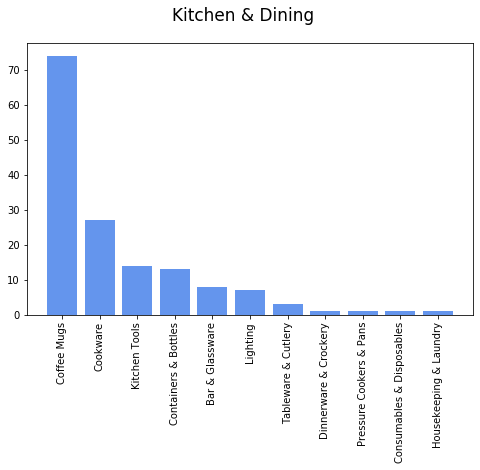

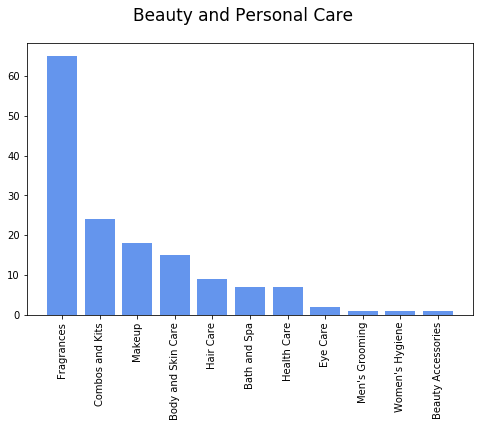

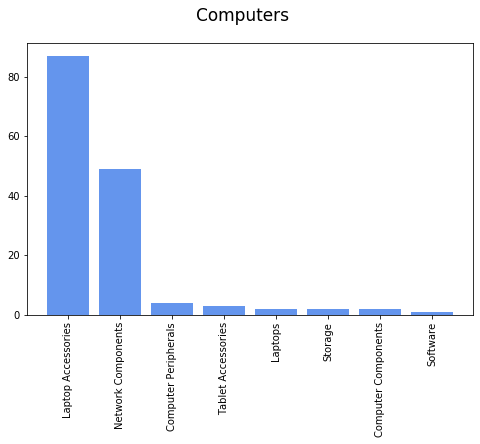

In [196]:
for i in data0['prod_cat_0'].unique():
    nombre_vals = data0[data0['prod_cat_0'] == i]['prod_cat_1'].value_counts()
    plt.rcParams["figure.figsize"] = (8,5)
    plt.bar(nombre_vals.index, nombre_vals.values, color=['cornflowerblue'])
    plt.suptitle(i, fontsize=17)
    plt.xticks(rotation=90) 
    plt.show()

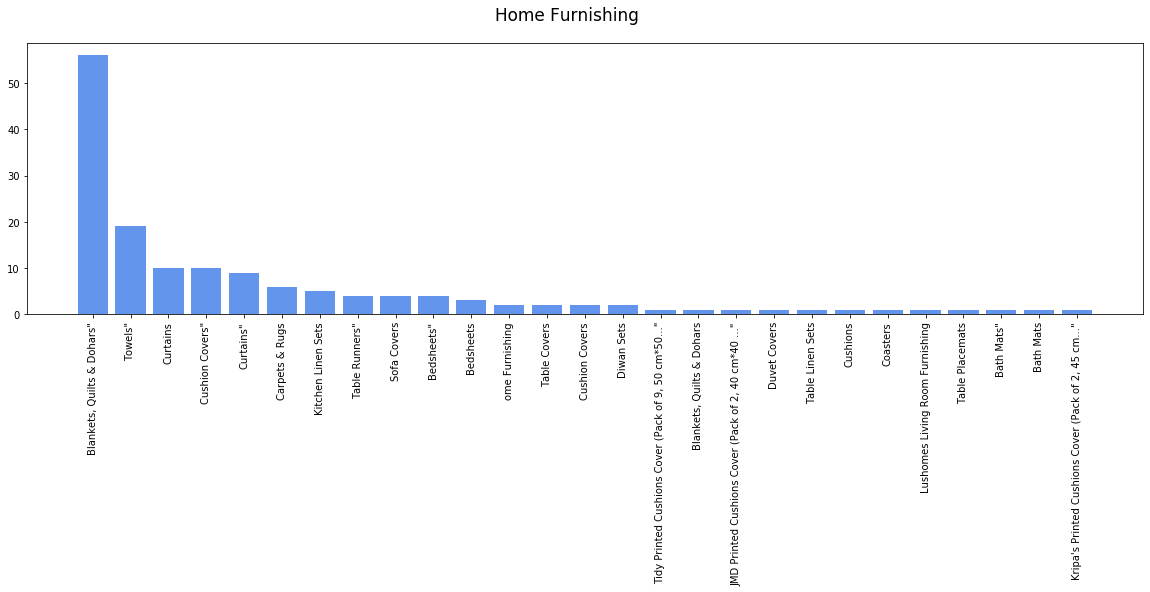

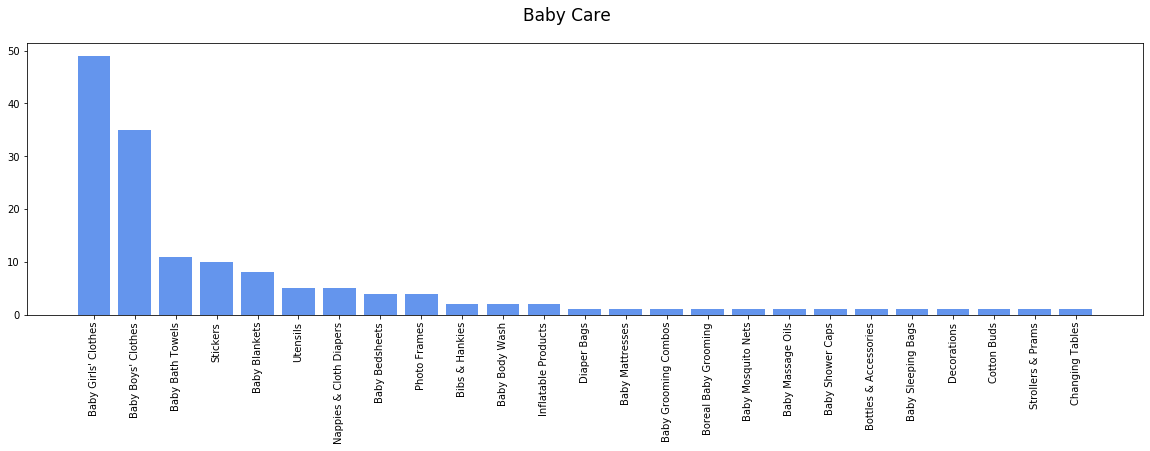

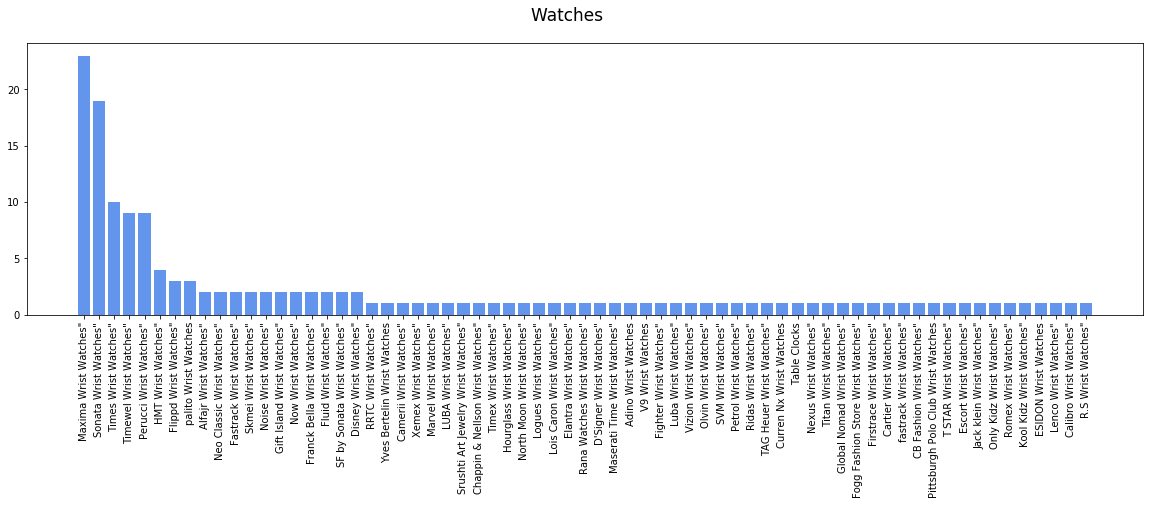

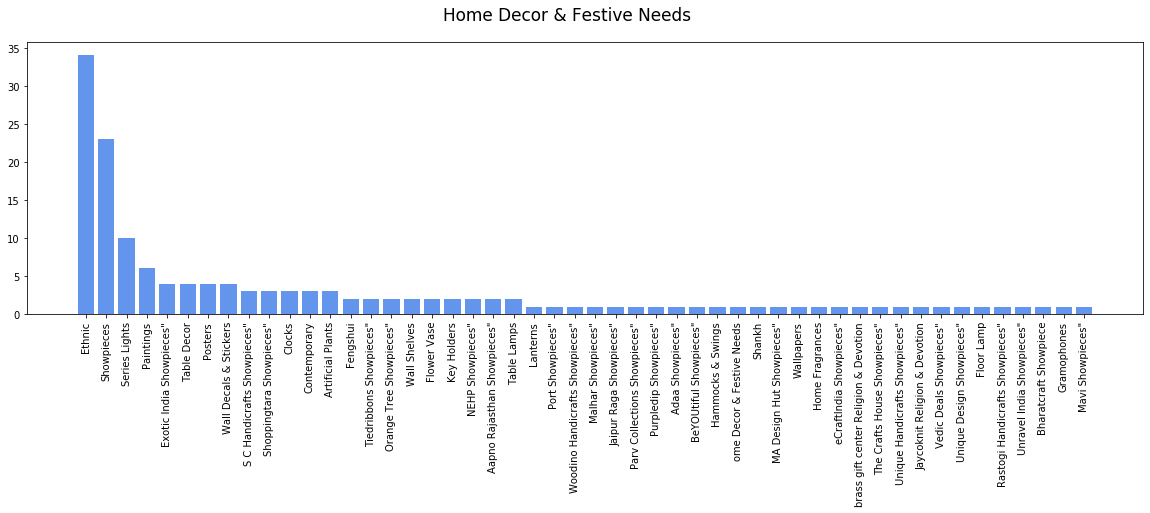

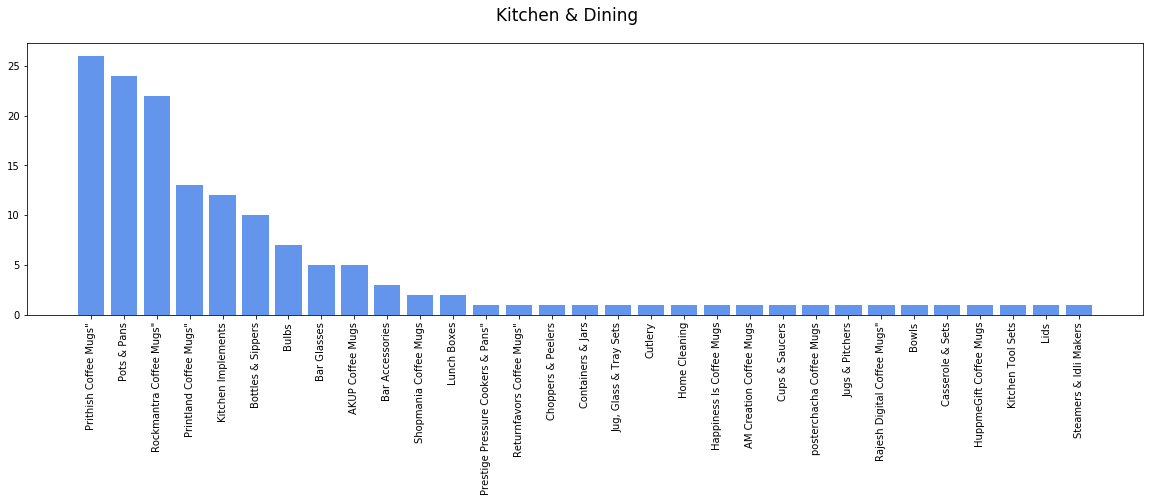

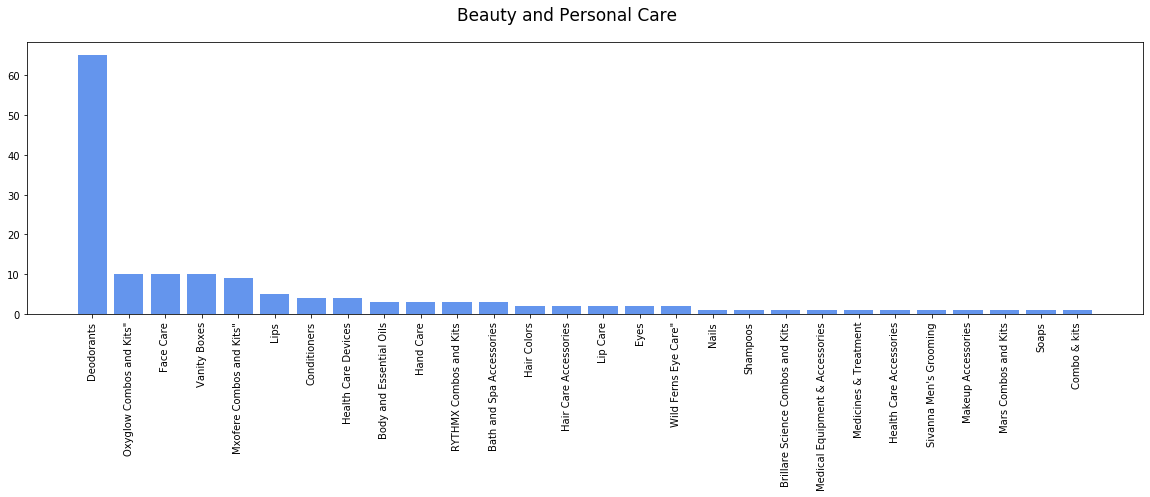

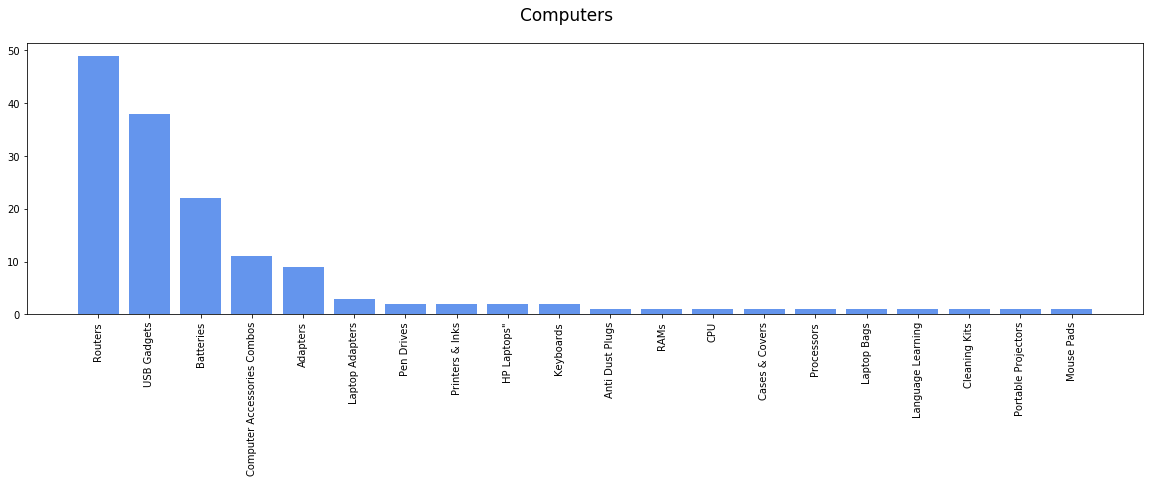

In [197]:
for i in data0['prod_cat_0'].unique():
    nombre_vals = data0[data0['prod_cat_0'] == i]['prod_cat_2'].value_counts()
    plt.rcParams["figure.figsize"] = (20,5)
    plt.bar(nombre_vals.index, nombre_vals.values, color=['cornflowerblue'])
    plt.suptitle(i, fontsize=17)
    plt.xticks(rotation=90) 
    plt.show()

# Création d'un idicateur de similarité

In [198]:
def mat_sim(a, b):

    # Cette fonction compare 2 clusterings.
    # Elle fonctionne sur un principe simple: dans une matrice de confusion,
    # le maximum d'occurences signifie que les 2 clusters associés sont
    # en fait le même cluster.
    # On peut alors éliminer ces 2 clusters de l'analyse et de la matrice
    # de confusion, puis recommencer l'identification.
    # La fonction renvoie:
    # 1) un score de similarité entre 0 (complètement différent) et 1
    #  (absolument identique)
    # 2) la correspondance des clusters entre les 2 clusterings

    import numpy as np
    from sklearn.metrics import confusion_matrix

    # On vérifie que les 2 listes ont le même nombre de clusters
    if len(np.unique(a)) != len(np.unique(b)):
        x = 'nombres de clusters différents!'
        y = 'nombres de clusters différents!'
    else:

        # Si tout va bien, on initie - et on calcule la matrice de confusion.
        # La copie initiale sera conservée (mat1), une 2e copie sera modifiée
        # au fur et à mesure (mat2).
        # La liste 'correspondance' identifiera les correspondances de clusters
        # entre les 2 entrées, sur la base de l'index dans la matrice
        # L'entier 'ok' sommera le nombre d'occurences pour les
        # correspondances sélectionnées.
        correspondance = []
        mat1 = confusion_matrix(a, b)
        mat2 = mat1
        ok = 0
        for i in range(0, len(np.unique(a)) - 1):
            mx = np.amax(mat2)
            if len(np.where(mat2 == mx)[0]) > 1:
                for j in (0, len(np.where(mat2 == mx)[0]) - 1):
                    if any(mx in l for l in mat2):
                        x1 = np.where(mat2 == mx)[0][0]
                        x2 = np.where(mat2 == mx)[1][0]
                        correspondance.append(
                            [np.where(mat1 == mx)[0][j],
                             np.where(mat1 == mx)[1][j]]
                        )
                        ok = ok + mx
                        mat2 = np.delete(mat2, x1, axis=0)
                        mat2 = np.delete(mat2, x2, axis=1)
            else:
                x1 = np.where(mat2 == mx)[0][0]
                x2 = np.where(mat2 == mx)[1][0]
                correspondance.append([
                    np.where(mat1 == mx)[0][0],
                    np.where(mat1 == mx)[1][0]])
                ok = ok + mx
                mat2 = np.delete(mat2, x1, axis=0)
                mat2 = np.delete(mat2, x2, axis=1)
        x = ok/np.sum(mat1)
        y = pd.DataFrame(
                correspondance,
                columns=['cluster1', 'cluster2'])
    return[x, y]

# Classification - base texte

Dans cette partie, je vais travailler sur le texte associé à chaque individu;

## Pré-traitement (product_name + description)

In [199]:
data1 = data0.copy()

### Filtre morpho-sytaxique

Je commence par exclure tout ce qui n'est pas nom.  
  
Les fonctions que je vais conserver:  
NN noun  
NNS noun plural  
NNP proper noun  
NNPS proper noun

In [200]:
fn_cons = ['NN', 'NNS', 'NNP', 'NNPS']

In [201]:
def filtre_fn (row):
    descr_reduite = []
    for d in nltk.pos_tag(nltk.word_tokenize(row)):
        if d[1] in fn_cons:
            descr_reduite.append(str(d[0]))
    return descr_reduite

In [202]:
data1['description_filt'] = data1['description'].apply(
                                        lambda x: filtre_fn(x))
data1['product_name_filt'] = data1['product_name'].apply(
                                        lambda x: filtre_fn(x))

In [203]:
data1['description_list'] = data1['description_filt'].values
data1['product_name_list']  = data1['product_name_filt'].values

### Exclusion stopwords

J'exclue des mots très fréquents, et à faible valeur ajoutée: les stopwords.

In [204]:
def remove_sw (row):
    return [x for x in row['description_list']
            if x not in nltk.corpus.stopwords.words('english')]

In [205]:
data1['description_list'] = data1.apply(lambda x: remove_sw(x), axis = 1)

In [206]:
def remove_sw (row):
    return [x for x in row['product_name_list']
            if x not in nltk.corpus.stopwords.words('english')]

In [207]:
data1['product_name_list'] = data1.apply(lambda x: remove_sw(x), axis = 1)

### Stemming

Je reviens à la racine des mots. Celà me permettra de considérer ensemble les singuliers et pluriels des mêmes mots, de décomposer certain mots composés, etc.

In [208]:
def stemm(row):
    return [PorterStemmer().stem(x) for x in row['description_list']]

In [209]:
data1['description_list'] = data1.apply(lambda x: stemm(x), axis = 1)

In [210]:
def stemm(row):
    return [PorterStemmer().stem(x) for x in row['product_name_list']]

In [211]:
data1['product_name_list'] = data1.apply(lambda x: stemm(x), axis = 1)

### Retour au format str

In [212]:
def list_to_str (row):
    return ' '.join(row)

In [213]:
data1['description_2'] = data1['description_list'].apply(
                                            lambda x: list_to_str(x))

In [214]:
data1['product_name_2'] = data1['product_name_list'].apply(
                                            lambda x: list_to_str(x))

## Classification - base texte - CountVectorizer

Je tente une première classification.

### CountVectorizer

Je décompose en utilisant un CountVectorizer.

In [215]:
liste_de_liste = data1['product_name_list'].values.tolist()
mots_uniques = list({x for l in liste_de_liste for x in l})
len(mots_uniques)

1932

In [216]:
vectorizer = CountVectorizer()
vectorizer.fit(mots_uniques)
print(vectorizer.vocabulary_)

{'kadhai': 916, 'unit': 1801, '125prog': 12, 'figh_008': 640, 'galaxi': 692, 'titrit': 1750, 'devic': 487, 'readi': 1435, 'width': 1880, 'mayursflora': 1079, 'freshen': 677, 'motif': 1136, 'fork': 668, 'rice': 1461, 'mini': 1110, 'wood': 1898, 'bluecensor': 245, 'sathiya': 1524, 'hdmi': 789, 'evil': 593, 'lx': 1031, 'park': 1278, 'omrd': 1238, 'hp': 828, 'stich': 1653, 'lga': 989, 'lucki': 1024, 'pc': 1288, '310': 28, 'attract': 159, 'brillar': 276, 'golmaalshop': 739, 'tslplt02': 1784, 'anjalika': 120, 'ghz': 716, 'lenovo': 986, 'popfun': 1357, 'piyo': 1319, 'sandal': 1517, 'bird': 233, 'yourself': 1929, '122': 9, 'wonderchef': 1897, 'wild': 1881, 'quilt': 1409, 'jmd': 901, 'essenti': 583, 'sonakshi': 1617, 'rt': 1495, 'n12': 1163, 'walldesign': 1858, 'ech': 556, 'bluetooth': 246, 'akup': 98, 'ar': 134, '7182wna': 49, 'pink': 1314, 'haircolor': 768, 'spf': 1631, 'merri': 1101, 'fancoolerbl': 618, 'showpiec': 1577, 'md7822u': 1090, 'sf': 1548, 'so': 1609, 'shea': 1560, 'keya': 933, '72

In [217]:
l = len(vectorizer.vocabulary_)
print(l)

1940


In [218]:
X = vectorizer.transform(data1['description_2'])

### t-SNE + K-Means

Puis je commence la classification, en premier en réduisant les dimensions va une ACP

In [219]:
# Calcul des composantes principales
pca = decomposition.TruncatedSVD(n_components=int(l*0.99))
pca.fit(X)

TruncatedSVD(algorithm='randomized', n_components=1920, n_iter=5,
             random_state=None, tol=0.0)

Puis via un TSNE

In [220]:
tsne = TSNE(n_components=2, 
            verbose=1, 
            perplexity=40, 
            n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.687489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.714256
[t-SNE] KL divergence after 300 iterations: 1.058900


Enfin je clusterise:

In [221]:
kmeans = KMeans(
         init="random",
         n_clusters=7,
         n_init=10,
         max_iter=300,
         random_state=42
         )

kmeans.fit(tsne_results)

clusters = kmeans.predict(tsne_results)

J'examine la qualité du clustering:

In [222]:
silhouette_score(X, clusters)

-0.055152411684997134

Et je regarde combien j'ai d'individu dans chaque groupe (d'après la référence, on a 150 individus par groupe).

In [223]:
Counter(clusters)

Counter({1: 113, 5: 205, 4: 158, 2: 151, 3: 190, 6: 109, 0: 124})

Je fais une représentation graphique, en utilisant les clusters de référence:

(-40, 40)

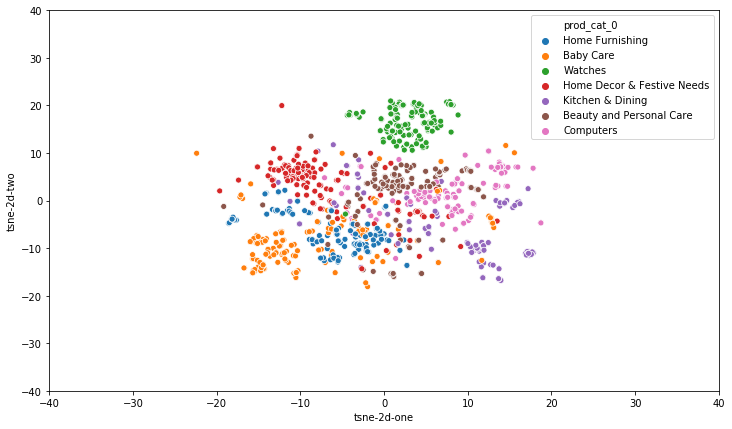

In [224]:
data1['tsne-2d-one'] = tsne_results[:,0]
data1['tsne-2d-two'] = tsne_results[:,1]
data1['clusters'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='prod_cat_0',
    data=data1
)
plt.ylim(-40, 40)
plt.xlim(-40, 40)

Voici la même représentation en utilisant les clusters que je viens d'effectuer:

(-40, 40)

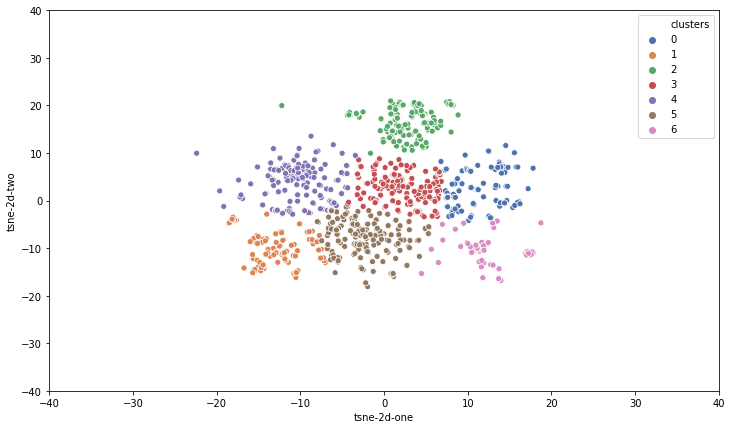

In [225]:
data1['tsne-2d-one'] = tsne_results[:,0]
data1['tsne-2d-two'] = tsne_results[:,1]
data1['clusters'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='clusters',
    data=data1, 
    palette="deep"
)
plt.ylim(-40, 40)
plt.xlim(-40, 40)

Je compare les 2 clusterisations par ARI:

In [226]:
adjusted_rand_score(
            data1['clusters'],
            data1['prod_cat_0'])

0.3962711879664704

### Test perplexity t-SNE

Parmi les paramètres du TNSE, ceux que je peux le moins facilement choisir sont la perplexité et
le random_state.  
Je vais donc tester différentes valeurs de perplexité, en évaluant la qualité du résultat en  
calculant l'ARI entre la classification utilisateur, et ma classification SIFT-KMeans.

In [227]:
perplexity = []
silhouette= []
ARI = []
for p in range(1,61):
    perplexity.append(p)
    tsne = TSNE(n_components=2, 
                verbose=0, 
                perplexity=p, 
                n_iter=300)
    tsne_results = tsne.fit_transform(X)
    kmeans.fit(tsne_results)
    clusters = kmeans.predict(tsne_results)
    silhouette.append(silhouette_score(X, clusters))
    data1['clusters'] = clusters
    ARI.append(adjusted_rand_score(
                data1['clusters'],
                data1['prod_cat_0']))

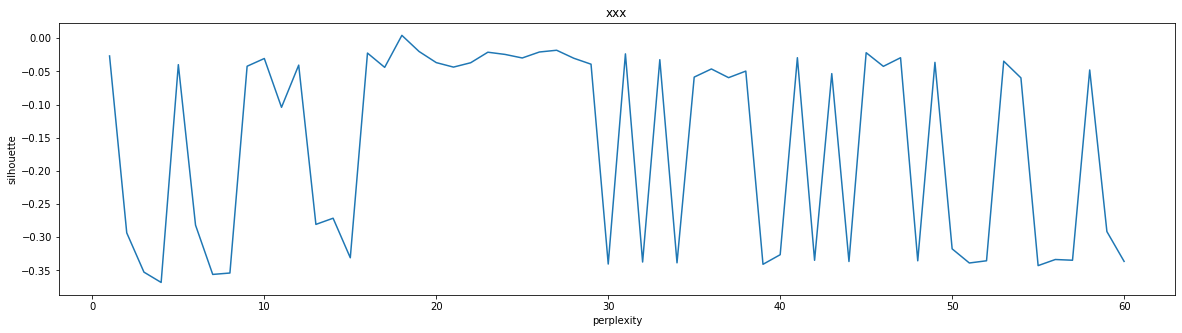

In [228]:
ax = plt.gca()

ax.plot(perplexity, silhouette)
plt.xlabel('perplexity')
plt.ylabel('silhouette')
plt.title('xxx')
plt.show()

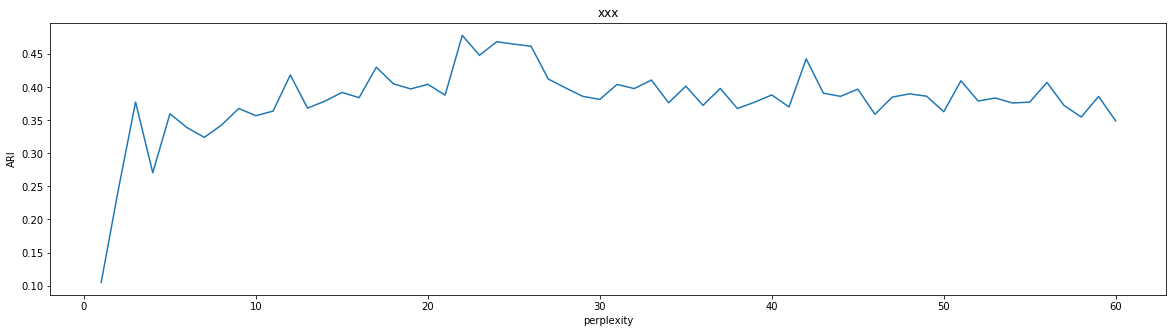

In [229]:
ax = plt.gca()

ax.plot(perplexity, ARI)
plt.xlabel('perplexity')
plt.ylabel('ARI')
plt.title('xxx')
plt.show()

##  Classification - base texte -Tfidf

Classification, cette fois-ci, avec un Tfidf.

### Tfidf

Je commence par une décomposition par tfidf

In [230]:
tfidf = TfidfVectorizer()
tfidf.fit(data1['product_name_list'].apply(lambda x: 
                                           list_to_str(x)).values.tolist())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [231]:
l = len(tfidf.vocabulary_)
print(l)

1940


In [232]:
X = tfidf.transform(data1['description_2'])

### t-SNE + k-Means

Puis je commence la classification, en premier en réduisant les dimensions va une ACP

In [233]:
# Calcul des composantes principales
pca = decomposition.TruncatedSVD(n_components=int(l*0.99), random_state=0)
pca.fit(X)

TruncatedSVD(algorithm='randomized', n_components=1920, n_iter=5,
             random_state=0, tol=0.0)

Puis via un TSNE

In [234]:
tsne = TSNE(n_components=2, 
            verbose=0, 
            perplexity=17,
            n_iter=300, 
            random_state=0)
tsne_results = tsne.fit_transform(X)

Enfin je clusterise:

In [235]:
kmeans = KMeans(
         init="random",
         n_clusters=7,
         n_init=10,
         max_iter=300,
         random_state=42
         )

kmeans.fit(tsne_results)

clusters = kmeans.predict(tsne_results)

J'examine la qualité du clustering:

In [236]:
silhouette_score(X, clusters)

0.033961030641051666

Et je regarde combien j'ai d'individu dans chaque groupe (d'après la référence, on a 150 individus par groupe).

In [237]:
Counter(clusters)

Counter({1: 169, 6: 141, 0: 143, 4: 106, 3: 179, 5: 140, 2: 172})

Je fais une représentation graphique, en utilisant les clusters de référence:

(-40, 40)

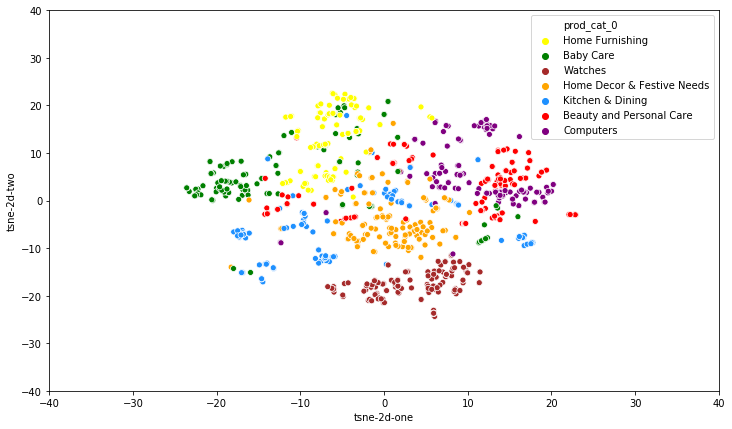

In [238]:
color_dict = dict({'Watches':'brown',
                  'Baby Care':'green',
                  'Home Decor & Festive Needs': 'orange',
                  'Beauty and Personal Care': 'red',
                   'Kitchen & Dining': 'dodgerblue',
                   'Computers': 'purple',
                   'Home Furnishing': 'yellow'})
data1['tsne-2d-one'] = tsne_results[:,0]
data1['tsne-2d-two'] = tsne_results[:,1]
data1['clusters'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='prod_cat_0',
    palette=color_dict,
    data=data1
)
plt.ylim(-40, 40)
plt.xlim(-40, 40)

Voici la même représentation en utilisant les clusters que je viens d'effectuer:

(-40, 40)

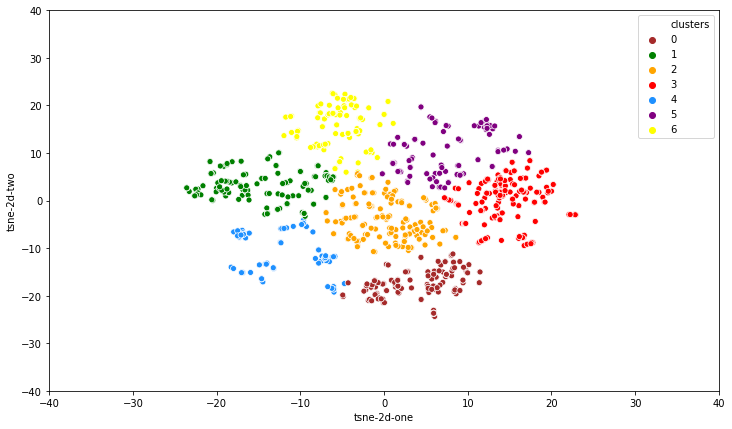

In [239]:
color_dict = dict({0:'brown',
                      1:'green',
                      2: 'orange',
                      3: 'red',
                      4: 'dodgerblue',
                     5: 'purple',
                    6: 'yellow'})
data1['tsne-2d-one'] = tsne_results[:,0]
data1['tsne-2d-two'] = tsne_results[:,1]
data1['clusters'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='clusters',
    data=data1, 
    palette=color_dict
)
plt.ylim(-40, 40)
plt.xlim(-40, 40)

Je compare les 2 clusterisations par ARI:

In [240]:
adjusted_rand_score(
            data1['clusters'],
            data1['prod_cat_0'])

0.44973219460028474

In [241]:
mat_sim(data1['clusters'],
        data0['prod_cat_0_bis'])[0]

0.6

### Classification - base texte - principaux contributeurs par catégorie

Dans cette sous-partie, je fais le lien entre les clusters à peine obtenus, et les features du tfidf, en sélectionnant, pour chaque cluster, les 15 racines lexicales les plus fréquentes.

In [289]:
data2 = pd.DataFrame(data=X.toarray(), columns=tfidf.get_feature_names())
data2['clusters'] = clusters

In [290]:
data2 = data2.groupby(['clusters']).sum()

In [294]:
for i in range(0,7):
    print(data2[tfidf.get_feature_names()].sort_values(by =i,ascending = False, axis = 1).iloc[i, : 15])

buy        31.801812
ship       30.825208
product    30.026770
day        29.100108
watch      28.847051
free       28.767358
replac     24.756028
india      22.882489
analog     22.873057
men        15.792528
women      12.486935
dial       12.184816
strap      11.542266
water       9.203402
sonata      8.319307
Name: 0, dtype: float64
babi      20.753342
gener     20.134072
pack      18.760323
girl      14.178233
cotton    13.173238
color     11.471649
box       11.063024
key       10.481533
code       9.802497
style      9.702035
dress      9.558153
wash       9.172972
print      9.146632
neck       9.002645
design     8.696093
Name: 1, dtype: float64
product     22.861226
cm          20.606545
buy         19.323850
day         18.929983
free        18.384125
showpiec    17.872073
replac      15.529147
inch         7.366348
box          7.281225
brass        6.242277
wall         5.750318
gift         4.974449
home         4.918602
color        4.879504
steel        4.826133
Name: 2

### Test perplexity t-SNE

Parmi les paramètres du TNSE, ceux que je peux le moins facilement choisir sont la perplexité et le random_state.  
Je vais donc tester différentes valeurs de perplexité, en évaluant la qualité du résultat en  
calculant l'ARI entre la classification utilisateur, et ma classification SIFT-KMeans.

In [73]:
perplexity = []
silhouette= []
ARI = []
for p in range(1,61):
    perplexity.append(p)
    tsne = TSNE(n_components=2, 
                perplexity=p, 
                n_iter=300)
    tsne_results = tsne.fit_transform(X)
    kmeans.fit(tsne_results)
    clusters = kmeans.predict(tsne_results)
    silhouette.append(silhouette_score(X, clusters))
    data1['clusters'] = clusters
    ARI.append(adjusted_rand_score(
                data1['clusters'],
                data1['prod_cat_0']))

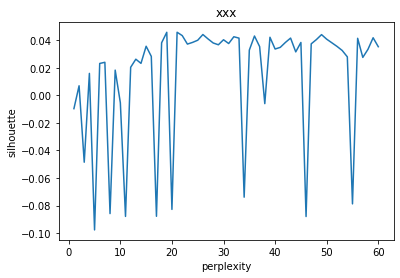

In [74]:
ax = plt.gca()

ax.plot(perplexity, silhouette)
plt.xlabel('perplexity')
plt.ylabel('silhouette')
plt.title('xxx')
plt.show()

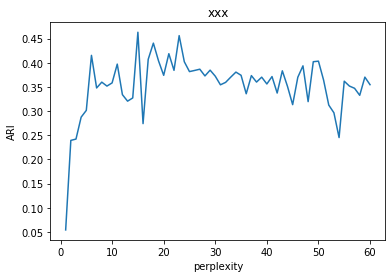

In [75]:
ax = plt.gca()

ax.plot(perplexity, ARI)
plt.xlabel('perplexity')
plt.ylabel('ARI')
plt.title('xxx')
plt.show()

# Classification - base image

## Classification - base image - SIFT

Dans cette partie, je vais tenter une classification en utilisant la méthode SIFT.

### Pré-traitement

Pré-traitement des images: redimensionnement, puis application d'un filtre.

In [76]:
data0['image3'] = data0['image2'].apply(lambda x: x.resize((400, 400)))

In [77]:
data0['image3'] = data0['image3'].apply(lambda x: x.filter(ImageFilter.GaussianBlur))

Autres alternatives de filtre:

In [78]:
#data0['image3'] = data0['image3'].apply(lambda x: x.filter(ImageFilter.BoxBlur(1)))

In [79]:
#data0['image3'] = data0['image3'].apply(lambda x: x.filter(ImageFilter.medianBlur))

In [80]:
#data0['image3'] = data0['image3'].apply(lambda x: ImageOps.equalize(x, mask=None))

In [81]:
#data0['image3'] = data0['image3'].apply(lambda x: ImageOps.autocontrast(x, cutoff=0, ignore=None))

### Construction du bag of image

Je créé ici un répertoire, qui permettra de classer les images, comme on le ferait dans la méthode bag of words. 
  
Pour celà, je vais extraire des features de toutes les images à ma disposition selon la méthode SIFT  
(max. 500 features par image), puis les regrouper en x clusters. Ce sont ces clusters qui constitueront  
la bibliothèque de référence pour la suite de l'analyse.

In [82]:
# Identification de l'ensemble des features:
des_list = []
feat_list = []
extractor = cv2.xfeatures2d.SIFT_create(nfeatures=500)

for im in data0['image3']:
    gray= cv2.cvtColor(np.asarray(im),cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = extractor.detectAndCompute(gray, None)
    des_list.append(descriptors)  # Appending all the descriptors into the single list
    if(not(descriptors is None)):
        for feat in descriptors:
            feat_list.append(feat)

In [83]:
# Je choisis la longueur de la bibliothèque de référence.
long_bibl = int(2*np.sqrt(len(feat_list)))

In [84]:
# Je créé la bibliothèque via un KMeans sur la liste totale de tous les features 
# de toutes les images:
kmeans = MiniBatchKMeans(n_clusters = long_bibl).fit(feat_list)

C:\Users\vince\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=886. Setting it to 3*k
  init_size=init_size)
C:\Users\vince\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=886. Setting it to 3*k
  init_size=init_size)
C:\Users\vince\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=886. Setting it to 3*k
  init_size=init_size)


Enfin, je référence tous les features de toutes les images dans la bibliothèque. En pratique, celà  
veut dire retourner, pour chaque image, un vecteur de dimension x, représentant la répartition de ses  
features identifiés entre les x catégories définies ci-dessus.  
  
Pour celà je vais parcourir chacun des descripteurs retournés par SIFT, et utiliser le KMeans fitté  
ci-dessus pour le faire entrer dans une catégorie.

In [85]:
# Création du bag of words pour toutes les images:
histo_list = []
sift =cv2.xfeatures2d.SIFT_create(nfeatures=500)

#for img in images_d_entraînement:
for img in data0['image3']:
    kp, des = sift.detectAndCompute(cv2.cvtColor(np.asarray(img),
                                                 cv2.COLOR_BGR2GRAY), 
                                    None)
    histo = np.zeros(long_bibl)
    nkp = np.size(kp)

    if nkp > 0:
        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)

J'ai maintenant l'équivalent d'un bag of words, sur lequel je peux travailler de manière similaire à  
ce que j'ai fait pour la partie texte de ce projet.

### Clusterisation: K-Means sur bag of image

#### PCA initial

Je commence par un PCA, pour réduire légèrement la dimension du problème.

In [86]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=0.99, random_state=0)
pca.fit_transform(histo_list)

array([[-5.34144474e-03, -8.46722365e-03,  9.21744695e-04, ...,
        -1.30033670e-03,  7.08162706e-04, -8.46827325e-04],
       [-6.22699718e-04,  3.26684545e-02, -3.08631310e-02, ...,
         2.00264579e-04,  1.48524282e-03,  1.66267531e-03],
       [-9.32001781e-03, -4.41067250e-03, -2.76061076e-03, ...,
         1.74449217e-03, -1.83377244e-03, -2.89398025e-03],
       ...,
       [-6.08346021e-03,  7.62605005e-04, -2.16931379e-03, ...,
         2.02429338e-03,  1.35272667e-03,  1.71117388e-05],
       [ 1.96667328e-02, -1.24287256e-02,  7.18545236e-03, ...,
         2.32694311e-03,  5.50199837e-04, -5.30544008e-04],
       [-1.24418900e-02, -5.95959039e-04, -1.88895776e-03, ...,
         1.20422744e-03,  2.27397226e-04, -2.26209983e-03]])

#### TSNE: recherche des meilleurs paramètres (perplexity)

Parmi les paramètres du TNSE, ceux que je peux le moins facilement choisir sont la perplexité et  
le random_state. Je vais donc tester différentes valeurs, en évaluant la qualité du résultat en  
calculant l'ARI entre la classification utilisateur, et ma classification SIFT-KMeans.

In [87]:
kmeans = KMeans(
         init="random",
         n_clusters=7,
         n_init=10,
         max_iter=1000,
         random_state=0
         )

ARI = []
param = []
PERPLEXITY = range(0, 100)

for i in PERPLEXITY:
    histo_list_2 = histo_list.copy()
    tsne = TSNE(n_components=2, 
                verbose=0, 
                perplexity=i, 
                n_iter=2000, 
                random_state=0)
    tsne_results = tsne.fit_transform(histo_list_2)
    kmeans.fit(tsne_results)
    clusters = kmeans.predict(tsne_results)
    ari = adjusted_rand_score(
            clusters,
            data0['prod_cat_0'])
    ARI.append(ari)
    param.append(i)

In [88]:
best_param = param[np.argmax(ARI)]
print('Meilleur ARI: ' + str(max(ARI)) 
      + ' (perplexity: ' + str(best_param))

Meilleur ARI: 0.04574764248514767 (perplexity: 89


In [89]:
print('ARI moyen: ' + str(np.mean(ARI)))

ARI moyen: 0.03564697444678664


#### TSNE: Application

Je recalcule la classification avec les paramètres sélectionnés dans la partie précédente, et je  
conserve le KMeans de classification correspondant.

In [90]:
tsne = TSNE(n_components=2, 
            verbose=1, 
            perplexity=best_param, 
            n_iter=2000, 
            random_state=0)
tsne_results = tsne.fit_transform(histo_list)

[t-SNE] Computing 268 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.134s...
[t-SNE] Computed neighbors for 1050 samples in 1.659s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.030596
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.722252
[t-SNE] KL divergence after 1600 iterations: 1.446479


In [91]:
kmeans = KMeans(
         init="random",
         n_clusters=7,
         n_init=10,
         max_iter=1000,
         random_state=42
         )

In [92]:
kmeans.fit(tsne_results)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

J'enregistre les clusters obtenus:

In [93]:
clusters = kmeans.predict(tsne_results)

Je calcule le score silhouette, pour avoir une idée de la qualité de la clusterisation:

In [94]:
silhouette_score(histo_list, clusters)

-0.05905522990993522

Nombre d'individus par catégorie (la classification utilisateur donnait 150 individus par catégorie):

In [95]:
Counter(clusters)

Counter({1: 118, 4: 155, 5: 117, 2: 144, 6: 178, 0: 337, 3: 1})

Je représente la classification utilisateur en 2 dimensions (merci le TSNE):

La classification "utilisateur":

(-10, 10)

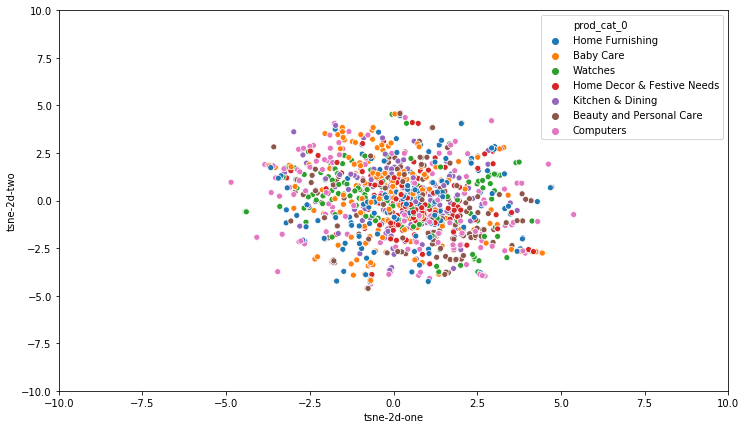

In [96]:
data0['tsne-2d-one'] = tsne_results[:,0]
data0['tsne-2d-two'] = tsne_results[:,1]
data0['clusters'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='prod_cat_0',
    data=data0
)
plt.ylim(-10, 10)
plt.xlim(-10, 10)

Je représente ma classification:

(-10, 10)

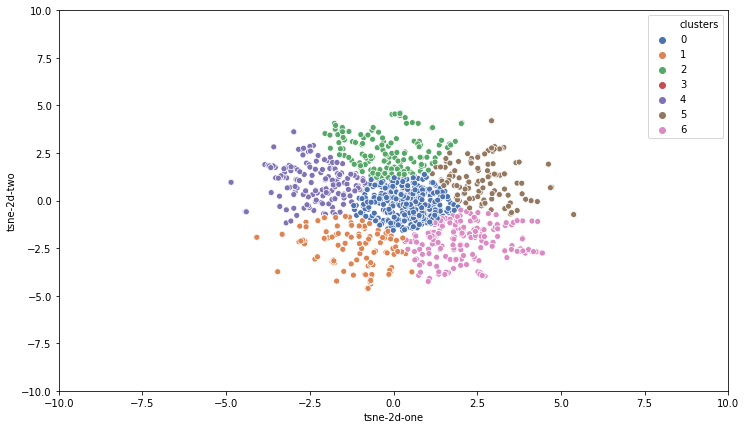

In [97]:
data0['tsne-2d-one'] = tsne_results[:,0]
data0['tsne-2d-two'] = tsne_results[:,1]
data0['clusters'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='clusters',
    data=data0, 
    palette="deep"
)
plt.ylim(-10, 10)
plt.xlim(-10, 10)

Et je retrouve le Rand Score (très laid):

In [98]:
adjusted_rand_score(
            data0['clusters'],
            data0['prod_cat_0'])

0.04574764248514767

## Classification - base image - CNN

Je vais maintenant tenter une classification en utilisant la méthode CNN.

### Pré-traitement

In [99]:
def pretraitement_CNN (row):
    image = row['image2'].resize((224, 224))
    image = keras.preprocessing.image.img_to_array(image)
    image = image.reshape((1, 
                           image.shape[0], 
                           image.shape[1], 
                           image.shape[2]))
    image = keras.applications.resnet.preprocess_input(image)
    return image

In [100]:
data0['image_CNN'] = data0.apply(lambda x: pretraitement_CNN(x), axis = 1)

### Extraction des features

Les features sont donnés par l'avant dernier niveau du classifier cNN.

In [101]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# get extracted features
data0['CNN_features_0'] = data0.apply(lambda x: model.predict(x['image_CNN'])[0], 
                                      axis = 1)

### PCA initial

Comme dans le cas du SIFT, je procède à un PCA, pour réduire légèrement la dimension du problème.

In [137]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=0.99, random_state=0)
data0['CNN_features_2'] = data0['CNN_features_0'].copy()
CNN_features_2 = data0['CNN_features_2'].tolist()
pca.fit_transform(CNN_features_2)

array([[ 2.63428027e+00, -1.30247023e+01, -6.44064282e+00, ...,
        -6.21480211e-01, -3.07413865e-01,  1.41499831e-01],
       [ 1.00410990e+00, -3.39002011e+01, -2.31074165e+01, ...,
        -4.47120456e-01,  3.11276817e-01,  1.43042747e-01],
       [-3.18906104e+00, -3.44649258e+01, -1.27472962e+01, ...,
         5.88501842e-01, -3.28902642e-02,  9.54335784e-01],
       ...,
       [-1.80318770e+01, -1.48969374e+01,  3.05836554e+00, ...,
        -2.07652475e-01, -1.78019374e-01,  2.28259473e-01],
       [-1.28228462e+01, -9.26942012e+00,  5.22096220e+00, ...,
        -1.90075344e-01, -7.05168950e-01, -1.85446545e-02],
       [-6.76616710e+00, -1.23873809e+01,  4.08856794e+00, ...,
         7.85982391e-01,  1.45462133e-01, -9.03748476e-01]])

### TSNE

#### TSNE: recherche des meilleurs paramètres (perplexity)

Comme dans le cas du SIFT, je teste différents paramètres pour le TSNE.

In [138]:
kmeans = KMeans(
         init="random",
         n_clusters=7,
         n_init=10,
         max_iter=1000,
         random_state=42
         )

ARI2 = []
param2 = []
PERPLEXITY2 = range(0, 25)

for i in PERPLEXITY2:
    CNN_features_3 = CNN_features_2.copy()
    tsne = TSNE(n_components=2, 
                verbose=0, 
                perplexity=i, 
                n_iter=2000, 
                random_state=0)
    tsne_results = tsne.fit_transform(CNN_features_3)
    kmeans.fit(tsne_results)
    clusters = kmeans.predict(tsne_results)
    ari = adjusted_rand_score(
            clusters,
            data0['prod_cat_0'])
    ARI2.append(ari)
    param2.append(i)

In [139]:
best_param2 = param2[np.argmax(ARI2)]
print('Meilleur ARI: ' + str(max(ARI2)) 
      + ' (perplexity: ' + str(best_param2))

Meilleur ARI: 0.5210701717189867 (perplexity: 12


In [140]:
print('ARI moyen: ' + str(np.mean(ARI2)))

ARI moyen: 0.421409313992706


#### TSNE: Application

Je relance avec les paramètres sélectionnés.

In [141]:
tsne = TSNE(n_components=2, 
            verbose=1, 
            perplexity=best_param2, 
            n_iter=2000, 
            random_state=0)
tsne_results = tsne.fit_transform(CNN_features_2)

[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 1050 samples in 1.103s...
[t-SNE] Computed neighbors for 1050 samples in 7.546s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 19.747273
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.625198
[t-SNE] KL divergence after 2000 iterations: 1.091576


In [142]:
kmeans.fit(tsne_results)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

J'enregistre les clusters obtenus:

In [143]:
clusters = kmeans.predict(tsne_results)

Je calcule le score silhouette, pour avoir une idée de la qualité de la clusterisation:

In [144]:
silhouette_score(histo_list, clusters)

-0.09620455909516165

Nombre d'individus par catégorie (la classification utilisateur donnait 150 individus par catégorie):

In [145]:
Counter(clusters)

Counter({5: 126, 1: 191, 4: 138, 0: 217, 6: 169, 3: 128, 2: 81})

Je représente la classification utilisateur en 2 dimensions:

La classification "utilisateur":

(-100, 100)

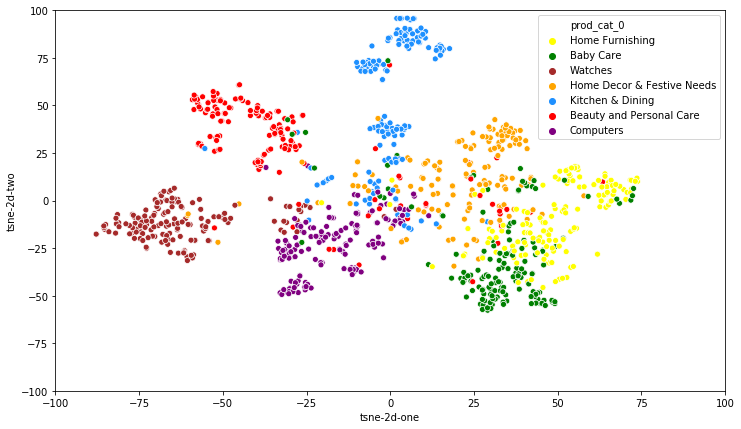

In [146]:
color_dict = dict({'Watches':'brown',
                  'Baby Care':'green',
                  'Home Decor & Festive Needs': 'orange',
                  'Beauty and Personal Care': 'red',
                   'Kitchen & Dining': 'dodgerblue',
                   'Computers': 'purple',
                   'Home Furnishing': 'yellow'})
data0['tsne-2d-one'] = tsne_results[:,0]
data0['tsne-2d-two'] = tsne_results[:,1]
data0['clusters_CNN'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='prod_cat_0',
    palette=color_dict,
    data=data0
)
plt.ylim(-100, 100)
plt.xlim(-100, 100)

La classification que je propose:

(-100, 100)

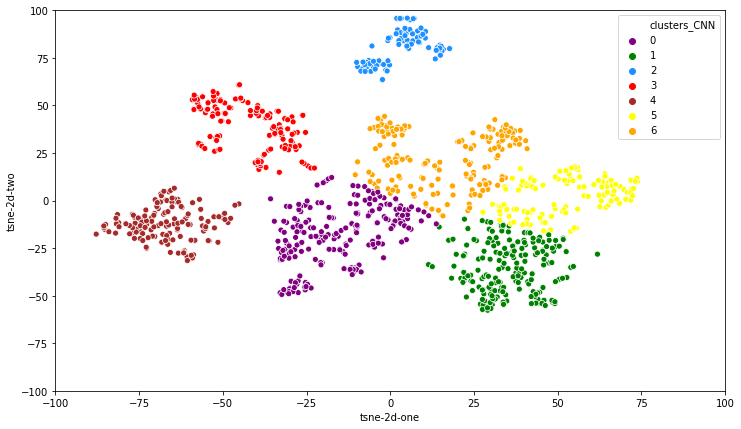

In [150]:
color_dict = dict({0:'purple',
                      1:'green',
                      2: 'dodgerblue',
                      3: 'red',
                      4: 'brown',
                     5: 'yellow',
                    6: 'orange'})
data0['tsne-2d-one'] = tsne_results[:,0]
data0['tsne-2d-two'] = tsne_results[:,1]
data0['clusters_CNN'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='clusters_CNN',
    data=data0, 
    palette=color_dict
)
plt.ylim(-100, 100)
plt.xlim(-100, 100)

J'obtiens cette fois un meilleur Rand Score:

In [148]:
adjusted_rand_score(
            data0['clusters_CNN'],
            data0['prod_cat_0'])

0.5210701717189867

In [149]:
mat_sim(data0['clusters_CNN'],
        data0['prod_cat_0_bis'])[0]

0.6638095238095238

# Classification - test + image

In [115]:
X = vectorizer.transform(data1['description_2'])

In [116]:
# X est une matrice éparse. Je réduis les dimensions.

tsvd = TruncatedSVD(n_components=int(X.shape[1]/10))
X_tsvd = tsvd.fit(X).transform(X)

In [117]:
Y = np.stack(data0['CNN_features_0'].tolist())

In [118]:
Z = np.concatenate((X_tsvd,Y),axis=1) 

In [119]:
pca = decomposition.PCA(n_components=0.99, random_state=0)
pca.fit_transform(Z)

array([[ 2.58281520e+00, -1.32399453e+01, -6.35597939e+00, ...,
         7.99929554e-01, -8.74398878e-01,  4.94499093e-01],
       [ 9.12200059e-01, -3.39818428e+01, -2.29130855e+01, ...,
         1.68198719e-03,  1.79735859e-01,  9.19799393e-01],
       [-3.18486546e+00, -3.47176288e+01, -1.26871268e+01, ...,
        -3.00690418e-01,  1.54677925e+00, -6.56574273e-01],
       ...,
       [-1.79930642e+01, -1.48225080e+01,  3.12562846e+00, ...,
        -1.28821589e-02,  1.16980847e-01,  1.48753122e-01],
       [-1.27925709e+01, -9.21504242e+00,  5.21665728e+00, ...,
        -5.14707651e-01, -6.03199658e-01, -4.30666784e-01],
       [-6.72998319e+00, -1.23131912e+01,  4.09658051e+00, ...,
         2.27183128e-01, -5.26062451e-02, -1.37648948e-03]])

In [120]:
kmeans = KMeans(
         init="random",
         n_clusters=7,
         n_init=10,
         max_iter=1000,
         random_state=42
         )

ARI3 = []
param3 = []
PERPLEXITY3 = range(0, 50)

for i in PERPLEXITY3:
    tsne = TSNE(n_components=2, verbose=0, perplexity=i, n_iter=2000, random_state=0)
    tsne_results = tsne.fit_transform(Z)
    kmeans.fit(tsne_results)
    clusters = kmeans.predict(tsne_results)
    ari = adjusted_rand_score(
            clusters,
            data0['prod_cat_0'])
    ARI3.append(ari)
    param3.append(i)

In [121]:
best_param3 = param3[np.argmax(ARI3)]
print('Meilleur ARI: ' + str(max(ARI3)) 
      + ' (perplexity: ' + str(best_param3))

Meilleur ARI: 0.5366125754590502 (perplexity: 37


In [122]:
clusters = kmeans.predict(tsne_results)

In [123]:
Counter(clusters)

Counter({1: 139, 4: 203, 5: 145, 0: 178, 2: 165, 6: 86, 3: 134})

(-50, 50)

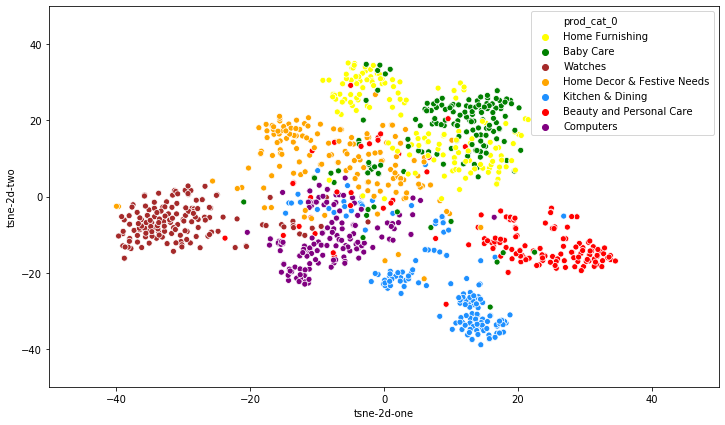

In [131]:
color_dict = dict({'Watches':'brown',
                  'Baby Care':'green',
                  'Home Decor & Festive Needs': 'orange',
                  'Beauty and Personal Care': 'red',
                   'Kitchen & Dining': 'dodgerblue',
                   'Computers': 'purple',
                   'Home Furnishing': 'yellow'})
data0['tsne-2d-one'] = tsne_results[:,0]
data0['tsne-2d-two'] = tsne_results[:,1]
data0['clusters_tot'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='prod_cat_0',
    palette=color_dict,
    data=data0
)
plt.ylim(-50, 50)
plt.xlim(-50, 50)

(-50, 50)

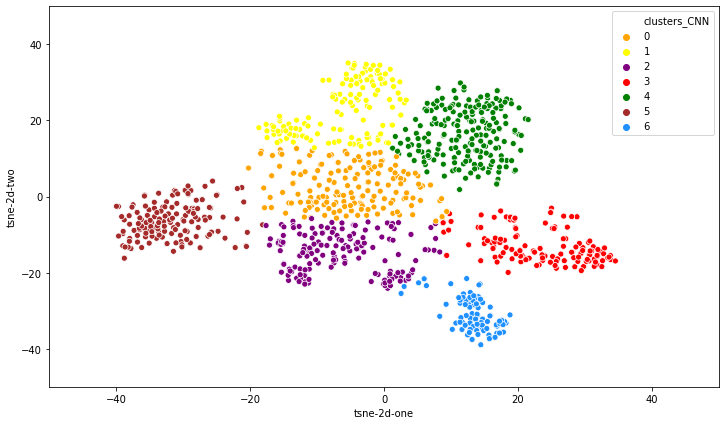

In [136]:
color_dict = dict({0:'orange',
                      1:'yellow',
                      2: 'purple',
                      3: 'red',
                      4: 'green',
                     5: 'brown',
                    6: 'dodgerblue'})
data0['tsne-2d-one'] = tsne_results[:,0]
data0['tsne-2d-two'] = tsne_results[:,1]
data0['clusters_tot'] = clusters
plt.figure(figsize=(12,7))
sns.scatterplot(
    x="tsne-2d-one", 
    y="tsne-2d-two",
    hue='clusters_CNN',
    data=data0, 
    palette=color_dict,
)
plt.ylim(-50, 50)
plt.xlim(-50, 50)

In [126]:
adjusted_rand_score(
            data0['clusters_tot'],
            data0['prod_cat_0'])

0.4635749579139265

In [127]:
mat_sim(data0['clusters_tot'],
        data0['prod_cat_0_bis'])[0]

0.6085714285714285